# Tutorial Explanation
In this tutorial, we will cover the following key concepts and steps:

1. **Introduction to the Problem**: We will start by understanding the problem we aim to solve. This includes defining the objectives and the expected outcomes.

2. **Nanoparticle Creation and Training Set Generation**: We will create nanoparticles using the `Nanoparticle` class and generate a training set of nanoparticles with specific stoichiometry using the `create_octahedron_training_set` function.

3. **Feature Extraction**: We will extract topological features from the nanoparticles using the `TopologicalFeatureClassifier` class.

4. **Model Training**: We will train a Bayesian Ridge Regression model using the extracted features and the `BayesianRRCalculator` class.

5. **Model Evaluation**: We will evaluate the model by examining the coefficients of the trained model and visualizing them using Matplotlib.

6. **Model Saving**: We will save the trained model to a file for future use.

Throughout this tutorial, we will use Python and popular libraries such as NumPy and Matplotlib. Each step will be accompanied by code examples and explanations to ensure a clear understanding of the concepts and processes involved.

Let's get started!


In [1]:
from npl.core import Nanoparticle
from npl.calculators import EMTCalculator

def create_octahedron_training_set(n_particles, height, trunc, stoichiometry):
    emt_calculator = EMTCalculator(fmax=0.03, steps=1000)
    
    training_set = []
    for i in range(n_particles):
        p = Nanoparticle()
        p.truncated_octahedron(height, trunc, stoichiometry)
        emt_calculator.compute_energy(p)
        training_set.append(p)
        
    return training_set


In [2]:
"""Create one randomly ordered start particle"""

def create_start_particle(height, trunc, stoichiometry):
    start_particle = Nanoparticle()
    start_particle.truncated_octahedron(height, trunc, stoichiometry)
    return start_particle

In [3]:
"""Create the training set with 30 particles"""
stoichiometry={'Pt' : 55, 'Au' : 24}

training_set = create_octahedron_training_set(15, 5, 1, stoichiometry)

In [4]:
from npl.descriptors import TopologicalFeatureClassifier

classifier = TopologicalFeatureClassifier(list(stoichiometry.keys()))

for p in training_set:
    classifier.compute_feature_vector(p)

In [5]:
from npl.calculators import BayesianRRCalculator

"""Create the calculator"""
calculator = BayesianRRCalculator(classifier.get_feature_key())
calculator.fit(training_set, 'EMT', validation_set=0.1)

Mean Absolute error 1.3016 eV
Root Mean Square error 1.4092 eV


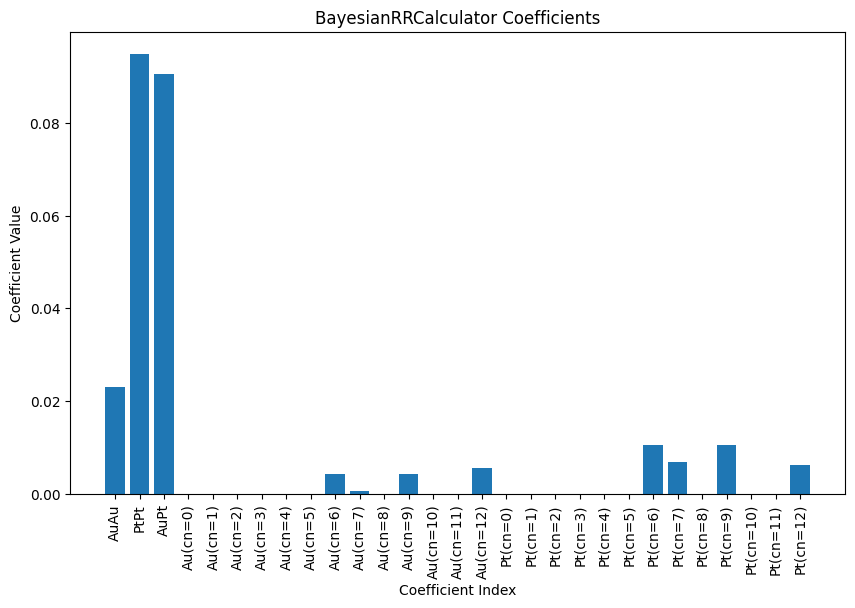

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Get the coefficients
coefficients = calculator.get_coefficients()
# Get the feature names from the classifier
feature_names = classifier.get_feature_labels()

# Plot the coefficients with feature names as x labels
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients)
plt.xticks(range(len(coefficients)), feature_names, rotation=90)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('BayesianRRCalculator Coefficients')
plt.show()

In [7]:
import pickle

# Save the BayesianRRCalculator object to a file
calculator.save('bayesian_rr_calculator.pkl')